<code style="color:blue"><font size="6"><b><u>Relatório: Inclusões nas Tabelas de Contactabilidade Salesforce"</u></b></font></code>

In [1]:
from datetime import datetime
data_atual = datetime.now()
data_e_hora_em_texto = data_atual.strftime('%d/%m/%Y %H:%M')
print('Data e horário da coleta dos dados: ', data_e_hora_em_texto)

Data e horário da coleta dos dados:  03/01/2023 08:40


In [2]:
# IMPORTANDO AS BIBLIOTECAS:

import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import text

# CONFIGURAÇÃO DO ACESSO REDSHIFT:

redshift_endpoint1 = "cluste-poc-rd.cu8dwwy21z1c.us-east-1.redshift.amazonaws.com"
redshift_user1 = "maresilva"
redshift_pass1 = "756OiFHPjaPbhYZ"
port1 = 5440 #whaterver your Redshift portnumber is
dbname1 = "poc-rd"

# CRIAÇÃO DA ENGINE DE SQL:

from sqlalchemy import create_engine
from sqlalchemy import text
engine_string = "postgresql+psycopg2://%s:%s@%s:%d/%s" \
% (redshift_user1, redshift_pass1, redshift_endpoint1, port1, dbname1)
engine1 = create_engine(engine_string)

In [3]:
inclusoes = """
select count(distinct(cd_cliente_unico)) cliente, 
(select count(distinct(cd_cliente_unico))  from rd_tru_campanha_crm.tru_contactabilidade_coleta_historico tcch 
where (dt_data_de between '2022-10-27' and sysdate))  coleta,
(select count(distinct(cd_cliente_unico)) from rd_tru_campanha_crm.tru_contactabilidade_lgpd_raia tclr 
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1') lgpd_raia,
(select count(distinct(cd_cliente_unico)) from rd_tru_campanha_crm.tru_contactabilidade_lgpd_drogasil
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1') lgpd_drogasil,
(select count(distinct(cd_cliente_unico)) from rd_tru_campanha_crm.tru_contactabilidade_supression_email_raia  
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1') email_raia,
(select count(distinct(cd_cliente_unico)) from rd_tru_campanha_crm.tru_contactabilidade_supression_email_drogasil  
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1') email_drogasil,
(select count(distinct(cd_cliente_unico)) from rd_tru_campanha_crm.tru_contactabilidade_exclusion_sms_raia  
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1') sms_raia,
(select count(distinct(cd_cliente_unico)) from rd_tru_campanha_crm.tru_contactabilidade_exclusion_sms_drogasil  
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1') sms_drogasil,
(select count(distinct(cd_cliente_unico)) from rd_cliente.dim_crm_contactabilidade
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1') dim_crm_contactabilidade
from rd_tru_campanha_crm.tru_contactabilidade_cliente
where (dt_data_de between '2022-10-27' and sysdate) and fl_ultima_versao = '1'
"""

In [4]:
tru_cliente = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_tru_campanha_crm.tru_contactabilidade_cliente
where fl_ultima_versao = '1'
group by dt_data_de
order by dt_data_de;
"""

In [5]:
checa_tru_cliente = pd.read_sql_query(text(tru_cliente), engine1)
#checa_tru_cliente

In [6]:
menores = checa_tru_cliente.loc[checa_tru_cliente['inclusoes']>1000000]
df = checa_tru_cliente.drop(menores.index)
df['dt_data_de'] = df['dt_data_de'].astype(str).str.replace('2022-','')

<img src="report_2.jpg" alt="Report" width="500" height="600">

<hr>

<p>O presente relatório contempla o acompanhamento diário, no <b><i>Ambiente de Produção</i></b>, de todas as tabelas da camada Trusted e na camada Refined do tema Contactabilidade do Salesforce.</p> <p>Tem como objetivo monitorar a ingestões diárias e elucidar eventuais desvios ou anormalidades nessas inclusões.</p>
<p>O monitoramento iniciou-se dia 27/10/2022 - data do início do tema Contactabilidade no ambiente de produção.</p>

<hr>

<code style="color:green"><font size="4"><b>Tabela Tru_Contactabilidade_Cliente</b></font><code>

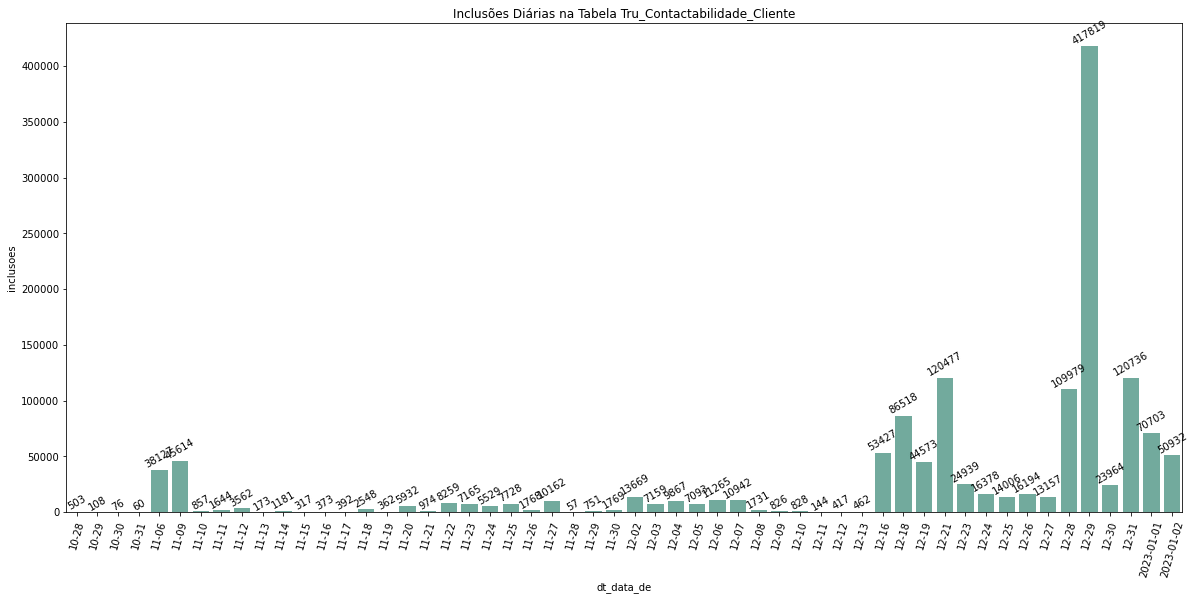

In [7]:
plt.figure(figsize=(20,9))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Tru_Contactabilidade_Cliente')
ax.tick_params(axis='x', rotation=74)

for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</font></p>
<li><font size='2'>Período de 01/11/2022 a 05/11/2022</li>
<li><font size='2'>Período de 07/11/2022 a 08/11/2022</li>
<li><font size='2'>Dia 01/12/2022</li>
<li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
<li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li>
<li><font size='2'>Dia 20/12/2022</li>
<li><font size='2'>Dia 22/12/2022</font></li>


In [8]:
tru_lgpd_drogasil = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_tru_campanha_crm.tru_contactabilidade_lgpd_drogasil
where fl_ultima_versao = '1'
group by dt_data_de 
order by dt_data_de;
"""

In [9]:
checa_tru_lgpd_drogasil = pd.read_sql_query(text(tru_lgpd_drogasil), engine1)
#checa_tru_lgpd_drogasil

In [10]:
menores = checa_tru_lgpd_drogasil.loc[checa_tru_lgpd_drogasil['inclusoes']>1000000]
df1 = checa_tru_lgpd_drogasil.drop(menores.index)
df1['dt_data_de'] = df1['dt_data_de'].astype(str).str.replace('2022-','')

<code style="color:green"><font size="4"><b>Tabela Tru_Contactabilidade_LGPD_Drogasil</b></font><code>

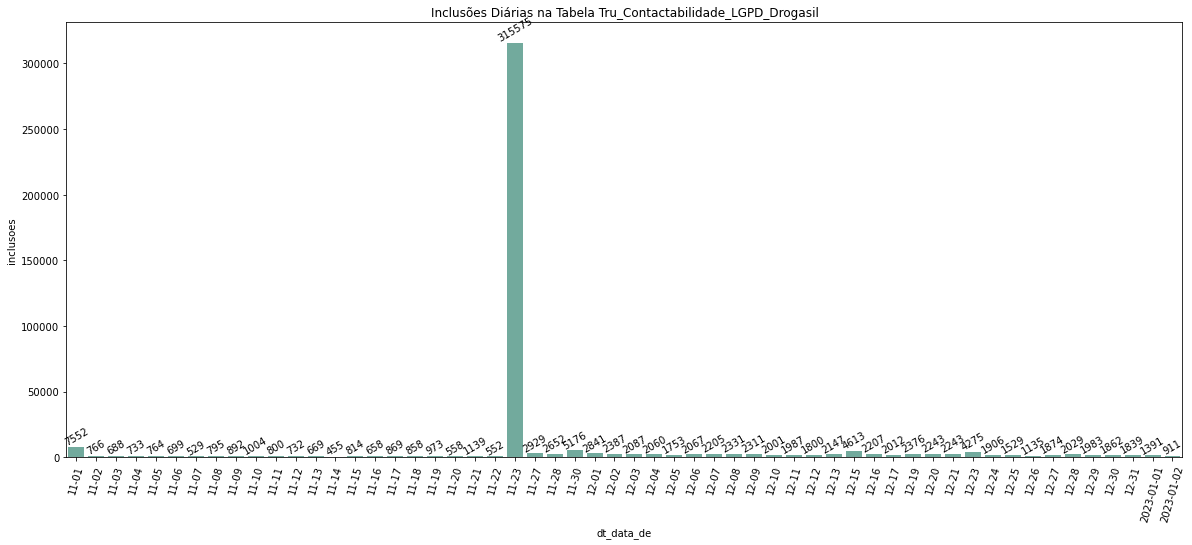

In [11]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df1, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Tru_Contactabilidade_LGPD_Drogasil')
ax.tick_params(axis='x', rotation=74)

for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</font></p>
<li><font size='2'>Período de 27/10/2022 a 31/10/2022</li>
<li><font size='2'>Período de 24/11/2022 a 26/11/2022</li>
<li><font size='2'>Dia 29/11/2022</li>
<li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
<li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li>
<li><font size='2'>Dia 22/12/2022</font></li>

In [12]:
tru_lgpd_raia = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_tru_campanha_crm.tru_contactabilidade_lgpd_raia
where fl_ultima_versao = '1'
group by dt_data_de 
order by dt_data_de;
"""

In [13]:
checa_tru_lgpd_raia = pd.read_sql_query(text(tru_lgpd_raia), engine1)
#checa_tru_lgpd_raia

In [14]:
menores = checa_tru_lgpd_raia.loc[checa_tru_lgpd_raia['inclusoes']>1000000]
df2 = checa_tru_lgpd_raia.drop(menores.index)
df2['dt_data_de'] = df2['dt_data_de'].astype(str).str.replace('2022-','')

<code style="color:green"><font size="4"><b>Tabela Tru_Contactabilidade_LGPD_Raia</b></font><code>

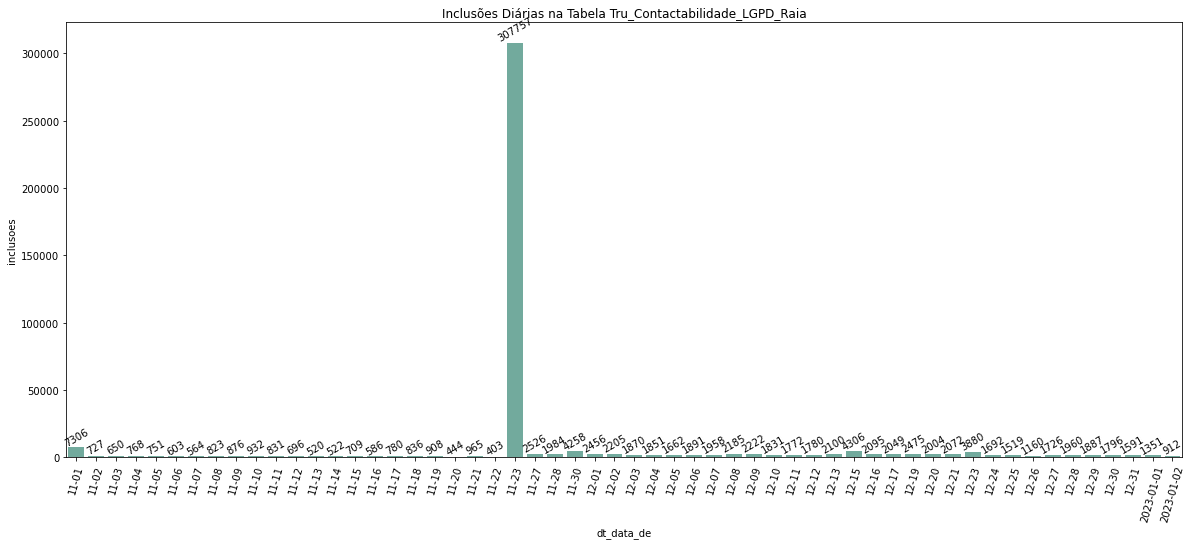

In [15]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df2, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Tru_Contactabilidade_LGPD_Raia')
ax.tick_params(axis='x', rotation=74)

for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</font></p>
<li><font size='2'>Período de 27/10/2022 a 31/10/2022</li>
<li><font size='2'>Período de 24/11/2022 a 26/11/2022</li>
<li><font size='2'>Dia 29/11/2022</li>
<li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
<li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li>
<li><font size='2'>Dia 22/12/2022</font></li>

In [16]:
tru_exclusion_sms_drogasil = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_tru_campanha_crm.tru_contactabilidade_exclusion_sms_drogasil
where fl_ultima_versao = '1'
group by dt_data_de 
order by dt_data_de;
"""

In [17]:
checa_tru_exclusion_sms_drogasil = pd.read_sql_query(text(tru_exclusion_sms_drogasil), engine1)
#checa_tru_exclusion_sms_drogasil

In [18]:
menores = checa_tru_exclusion_sms_drogasil.loc[checa_tru_exclusion_sms_drogasil['inclusoes']>1000000]
df3 = checa_tru_exclusion_sms_drogasil.drop(menores.index)
df3['dt_data_de'] = df3['dt_data_de'].astype(str).str.replace('2022-','')

<hr>

<code style="color:green"><font size="4"><b>Tabela Tru_Contactabilidade_Exclusion_Sms_Drogasil</b></font><code>

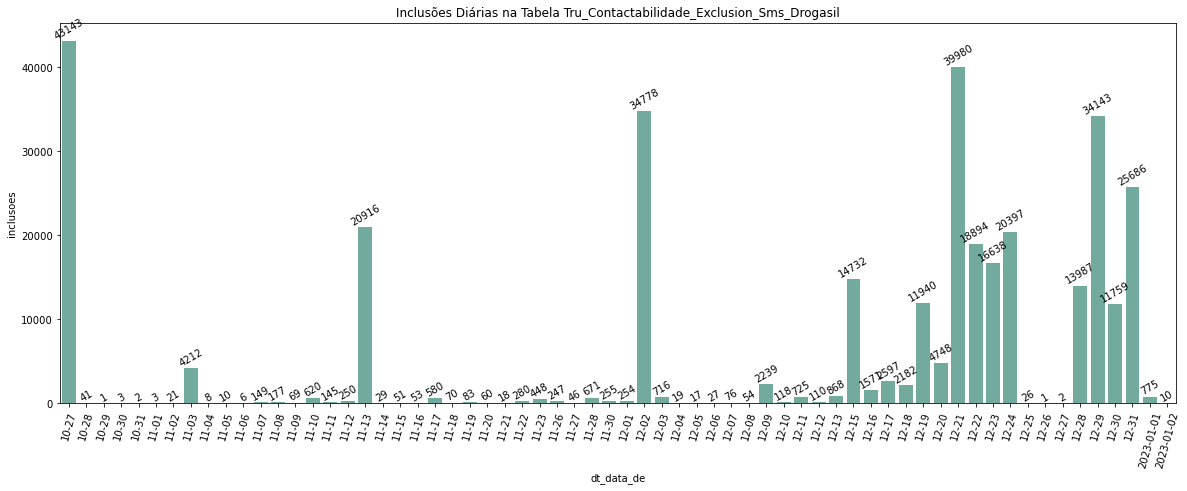

In [19]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df3, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Tru_Contactabilidade_Exclusion_Sms_Drogasil')
ax.tick_params(axis='x', rotation=74)

for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</font></p>
<li><font size='2'>Período de 24/11/2022 a 25/11/2022</li>
<li><font size='2'>Dia 29/11/2022</li>
<li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
<li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li></font>
        

In [20]:
tru_exclusion_sms_raia = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_tru_campanha_crm.tru_contactabilidade_exclusion_sms_raia
where fl_ultima_versao = '1'
group by dt_data_de 
order by dt_data_de;
"""

In [21]:
checa_tru_exclusion_sms_raia = pd.read_sql_query(text(tru_exclusion_sms_raia), engine1)
#checa_tru_exclusion_sms_raia

In [22]:
menores = checa_tru_exclusion_sms_raia.loc[checa_tru_exclusion_sms_raia['inclusoes']>1000000]
df4 = checa_tru_exclusion_sms_raia.drop(menores.index)
df4['dt_data_de'] = df4['dt_data_de'].astype(str).str.replace('2022-','')

<code style="color:green"><font size="4"><b>Tabela Tru_Contactabilidade_Exclusion_Sms_Raia</b></font><code>

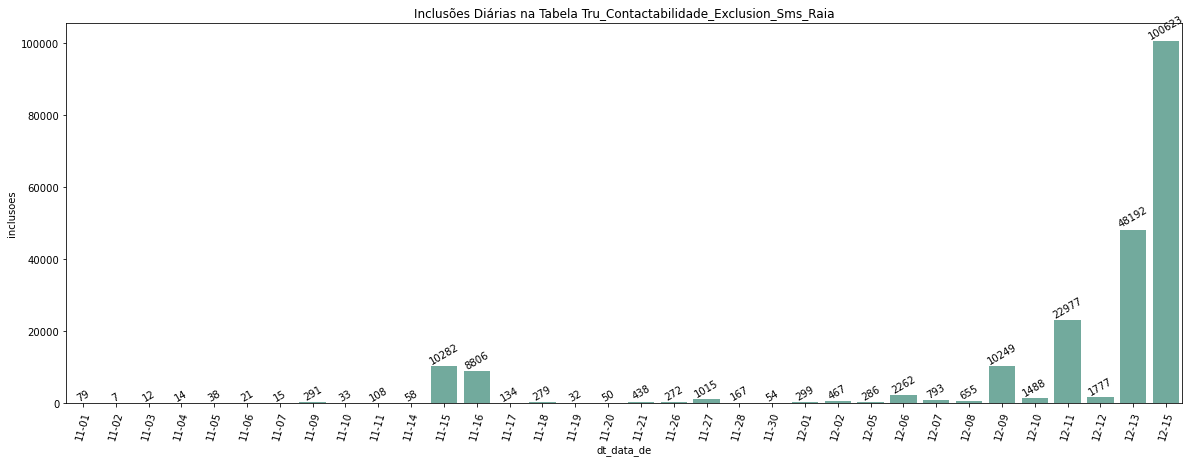

In [23]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df4, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Tru_Contactabilidade_Exclusion_Sms_Raia')
ax.tick_params(axis='x', rotation=74)

for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</p> 
<li><font size='2'>Período de 27/10/2022 a 31/10/2022</li>
    <li><font size='2'>Dia 08/11/2022</li>
    <li><font size='2'>Período de 12/11/2022 a 13/11/2022</li>
    <li><font size='2'>Período de 22/11/2022 a 25/11/2022</li>
    <li><font size='2'>Dia 29/11/2022</li>
    <li><font size='2'>Período de 03/12/2022 a 04/12/2022</li>
  <li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
<li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li>
    <li><font size='2'>Período de 16/12/2022 a Atualmente</li></font>

In [24]:
tru_supression_email_drogasil = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_tru_campanha_crm.tru_contactabilidade_supression_email_drogasil
where fl_ultima_versao = '1'
group by dt_data_de 
order by dt_data_de;
"""

In [25]:
checa_tru_supression_email_drogasil = pd.read_sql_query(text(tru_supression_email_drogasil), engine1)
#checa_tru_supression_email_drogasil

In [26]:
menores = checa_tru_supression_email_drogasil.loc[checa_tru_supression_email_drogasil['inclusoes']>1000000]
df5 = checa_tru_supression_email_drogasil.drop(menores.index)
df5['dt_data_de'] = df5['dt_data_de'].astype(str).str.replace('2022-','')

<hr>

<code style="color:green"><font size="4"><b>Tabela Tru_Contactabilidade_Supression_Email_Drogasil</b></font><code>

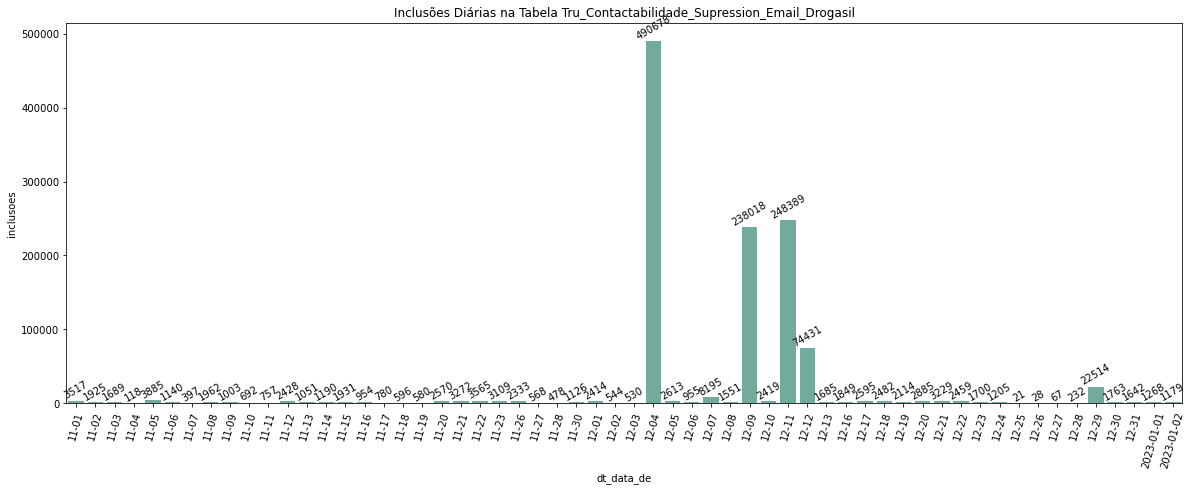

In [27]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df5, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Tru_Contactabilidade_Supression_Email_Drogasil')
ax.tick_params(axis='x', rotation=74)

for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</font></p>
<li><font size='2'>Período de 27/10/2022 a 31/10/2022</li>
<li><font size='2'>Período de 24/11/2022 a 26/11/2022</li>
<li><font size='2'>Dia 29/11/2022</li>
<li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
<li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li></font>
        

In [28]:
tru_supression_email_raia = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_tru_campanha_crm.tru_contactabilidade_supression_email_raia
where fl_ultima_versao = '1'
group by dt_data_de 
order by dt_data_de;
"""

In [29]:
checa_tru_supression_email_raia = pd.read_sql_query(text(tru_supression_email_raia), engine1)
#checa_tru_supression_email_raia

In [30]:
menores = checa_tru_supression_email_raia.loc[checa_tru_supression_email_raia['inclusoes']>1000000]
df6 = checa_tru_supression_email_raia.drop(menores.index)
df6['dt_data_de'] = df6['dt_data_de'].astype(str).str.replace('2022-','')

<code style="color:green"><font size="4"><b>Tabela Tru_Contactabilidade_Supression_Email_Raia</b></font><code>

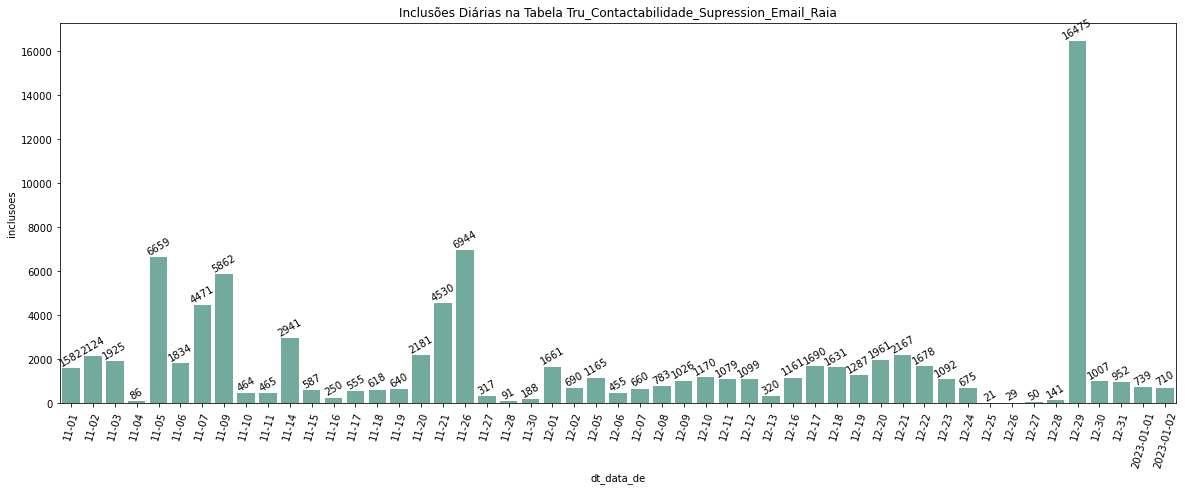

In [31]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df6, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Tru_Contactabilidade_Supression_Email_Raia')
ax.tick_params(axis='x', rotation=74)


for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</font></p>
<li><font size='2'>Período de 27/10/2022 a 31/10/2022</li>
<li><font size='2'>Dia 08/11/2022</li>
<li><font size='2'>Período de 12/11/2022 a 13/11/2022</li>
<li><font size='2'>Período de 22/11/2022 a 25/11/2022</li>
<li><font size='2'>Dia 29/11/2022</li>
<li><font size='2'>Período de 03/12/2022 a 04/12/2022</li>
<li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
  <li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li>
        

In [32]:
dim_crm_contactabilidade = """
select count(distinct(cd_cliente_unico)) inclusoes, dt_data_de from rd_cliente.dim_crm_contactabilidade
where fl_ultima_versao = '1'
group by dt_data_de 
order by dt_data_de;
"""

In [33]:
checa_dim_crm_contactabilidade = pd.read_sql_query(text(dim_crm_contactabilidade), engine1)
#checa_dim_crm_contactabilidade

<hr>

<code style="color:green"><font size="4"><b>Tabela Dim_CRM_Cliente</b></font><code>

In [34]:
menores = checa_dim_crm_contactabilidade.loc[checa_dim_crm_contactabilidade['inclusoes']>1000000]
df7 = checa_dim_crm_contactabilidade.drop(menores.index)
df7['dt_data_de'] = df7['dt_data_de'].astype(str).str.replace('2022-','')

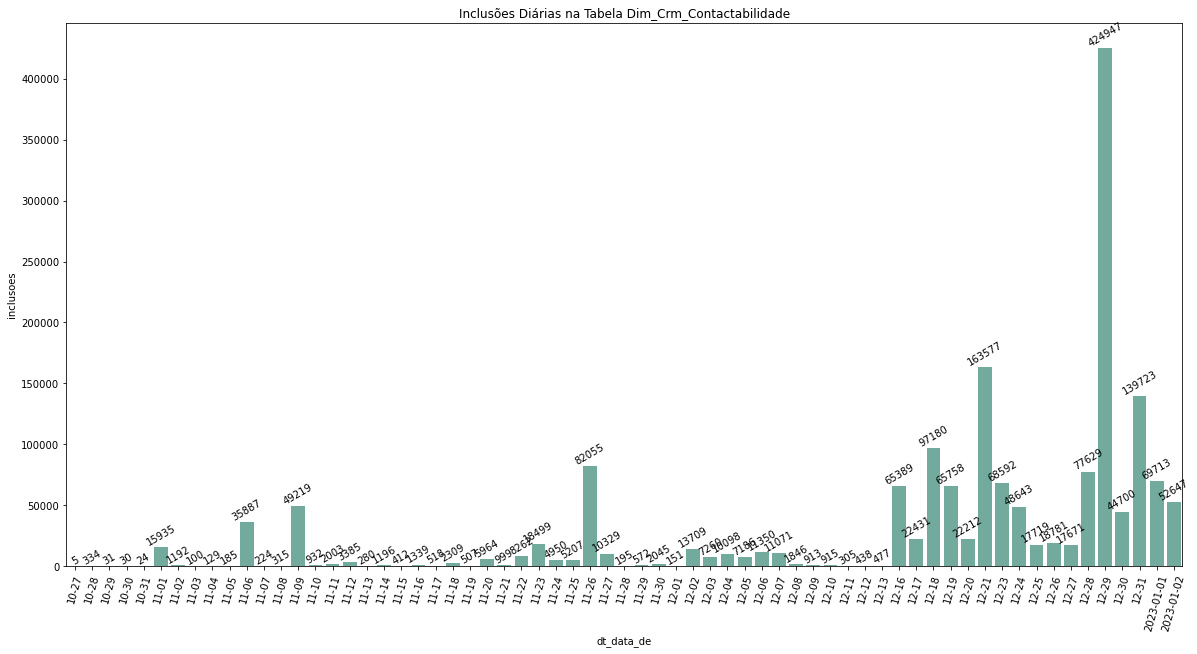

In [35]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x = 'dt_data_de', y = 'inclusoes', data = df7, color='#69b3a2')
ax.set_title('Inclusões Diárias na Tabela Dim_Crm_Contactabilidade')
ax.tick_params(axis='x', rotation=74)


for i in ax.containers:
    ax.bar_label(i, rotation=30)

    
ax
print()

<p><font size='3.5'><b>Observações:</b></font></p>
<p><font size='3'>Interrupção na replicação dos dados do Aws Athena para o Aws Redshift (Schema Rd_Ext_Salesforce) nas seguintes datas:</font></p>
<li><font size='2'>Dia 14/12/2022 - Pausado Processo de Atualização Diária - Inclusao dos dois novos flags nas tabelas de Clientes</li>
<li><font size='2'>Dia 15/12/2022 - Carregado a atualização com os dois novos flags "Possui App Drogasil" e "Possui App Raia"</li>
<li><font size='2'>Dia 22/12/2022</font></li>